In [1]:
import math
from datetime import datetime, timedelta
from functools import partial
import tqdm

import h3
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pyproj
import geopandas

from shapely.strtree import STRtree
from shapely.geometry import Point, MultiPoint, Polygon
from shapely.ops import cascaded_union, transform

In [2]:
incident_df = pd.read_pickle('output/tdot_12_incidents.pkl')
incident_df['time'] = pd.to_datetime(incident_df['timestamp'], unit='s')

In [3]:
report_df = pd.read_csv('output/waze_12_etrims.csv', index_col=0)
# pubMillis (NUMERIC) - milliseconds since epoch
report_df['time'] = pd.to_datetime(report_df['pubMillis'], unit='ms')
dist_to_segment = 1  # distance in degrees
report_df = report_df[report_df.seg_id_dist * 1000 < dist_to_segment]

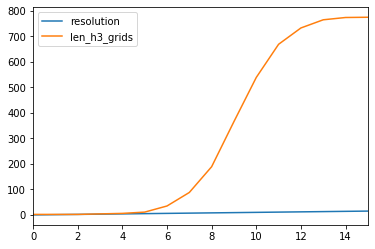

In [4]:
grid_size_resolution = []

for resolution in range(16):
    h3_grids = [h3.geo_to_h3(lat, lng, resolution) for lat, lng in zip(incident_df.lat, incident_df.lng)]
    grid_size_resolution.append({
        'resolution': resolution,
        'len_h3_grids': len(np.unique(h3_grids)),
    })
    
grid_size_resolution_df = pd.DataFrame(grid_size_resolution)

grid_size_resolution_df.plot.line()

In [5]:
def project_coordinates(lng, lat, radius=None):
    local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(lat, lng)
    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
        pyproj.Proj(local_azimuthal_projection),
    )
    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
    )
    center = Point(float(lng), float(lat))
    point_transformed = transform(wgs84_to_aeqd, center)
    if radius is not None:
        buffer = point_transformed.buffer(radius) # in meters
    else:
        buffer = point_transformed
    # Get the polygon with lat lon coordinates
    return transform(aeqd_to_wgs84, buffer)

(-122.44267457650938, 37.76497878394082, -122.41991942349063, 37.78296521605919)
(37.773972, -122.431297)

86283082fffffff
((37.74066613210137, -122.40813889567377), (37.76546768434345, -122.37681938644465), (37.79831548273904, -122.38694609754087), (37.80635261649481, -122.42840891818561), (37.78154533060492, -122.45971797898419), (37.74870664801546, -122.44957468417971))

(-122.45971797898419, 37.74066613210137, -122.37681938644465, 37.80635261649481)

0.0003209347924537753

86264d027ffffff
86264d107ffffff
86264d11fffffff
86264d12fffffff
86264d157ffffff
86264d177ffffff


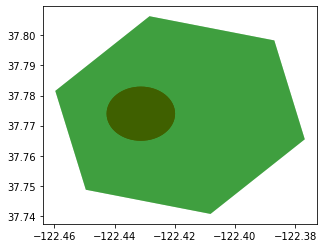

In [30]:
# Example grid - incident overlap
lng, lat = -122.431297, 37.773972 # lon lat for San Francisco (from StackOverflow)

radius = 1000  # in m

aperture_size = 6  # Grid Resolution

buffer = project_coordinates(lng, lat, radius)

print(buffer.bounds)

pt = project_coordinates(lng, lat)

print((pt.y, pt.x), end='\n\n')

print(h3.geo_to_h3(pt.y, pt.x, aperture_size))

boundary = h3.h3_to_geo_boundary(h3.geo_to_h3(pt.y, pt.x, aperture_size))

print(boundary, end='\n\n')

grid = Polygon([(x, y) for (y, x) in boundary])

print(grid.bounds, end='\n\n')

print(grid.intersection(buffer).area, end='\n\n')

df1 = geopandas.GeoDataFrame({'geometry': buffer, 'df1':[1,2]})

df2 = geopandas.GeoDataFrame({'geometry': grid, 'df2':[1,2]})

ax = df1.plot(color='red');

df2.plot(ax=ax, color='green', alpha=0.5);

for pt in h3_get_neighbors('86264d10fffffff'):
    boundary = h3.h3_to_geo_boundary(h3.geo_to_h3(pt.y, pt.x, aperture_size))
    grid = Polygon([(x, y) for (y, x) in boundary])
    df3 = geopandas.GeoDataFrame({'geometry': grid, 'df2':[1,2]})
    df3.plot(ax=ax, color='green', alpha=0.5);

In [14]:
incident_df[hex_col]

Polygon([(x, y) for (y, x) in boundary])

8       86264dc77ffffff
9       86264dd5fffffff
10      86264dd5fffffff
11      86264dc77ffffff
34      86264dc67ffffff
             ...       
6921    86264d10fffffff
6922    86264d10fffffff
6923    86264d10fffffff
6924    86264d10fffffff
6956    86264d10fffffff
Name: hex6, Length: 818, dtype: object

In [29]:
def h3_get_neighbors(region):
    if region.startswith('r_'):
        region = region[2:]
    return [x for x in np.unique(incident_df[hex_col]) if h3.h3_indexes_are_neighbors(region, x)]
        


['86264d027ffffff',
 '86264d107ffffff',
 '86264d11fffffff',
 '86264d12fffffff',
 '86264d157ffffff',
 '86264d177ffffff']

In [28]:
waze_report_uncertainty_regions = []
for lng, lat in tqdm.tqdm(list(zip(report_df.lng, report_df.lat))):
    waze_report_uncertainty_regions.append(project_coordinates(lng, lat, radius))

  3%|▎         | 206/6161 [00:15<07:38, 12.98it/s]


KeyboardInterrupt: 

In [ ]:
# Functions
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16, 12), colormap='viridis'):
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize)
    plt.xticks([], [])
    plt.yticks([], [])
    
hex_col = 'hex' + str(aperture_size)

# find hexs containing the points
incident_df[hex_col] = incident_df.apply(lambda x: h3.geo_to_h3(x.lat, x.lng, aperture_size), 1)

# aggregate the points
incident_g_df = incident_df.groupby(hex_col).size().to_frame('cnt').reset_index()

# find center of hex for visualization
incident_g_df['lat'] = incident_g_df[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
incident_g_df['lng'] = incident_g_df[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# pltot the hexs
plot_scatter(incident_g_df, metric_col='cnt', marker='o', figsize=(16, 12))
plt.title('hex-grid: accidents (incident)')

In [ ]:
grid_cell_hex_index = np.unique(incident_df[hex_col])

grid_cell_hex_bound = [h3.h3_to_geo_boundary(h) for h in grid_cell_hex_index]

grid_cells_hex = [Polygon([(x, y) for (y, x) in h]) for h in grid_cell_hex_bound]

grid_cell_index_by_id = dict((id(c), i) for i, c in zip(grid_cell_hex_index, grid_cells_hex))
grid_cell_index = STRtree(grid_cells_hex)

In [ ]:
likelihood = []

for waze_report_region in tqdm.tqdm(waze_report_uncertainty_regions):
    _probs = []
    _total_overlap_area = 0.0
    for grid_cell in grid_cell_index.query(waze_report_region):
        region_intersect = grid_cell.intersection(waze_report_region)
        _id = grid_cell_index_by_id[id(grid_cell)]
        _overlap_area = region_intersect.area
        _total_overlap_area += _overlap_area
        if _overlap_area > 0.0:
            _probs.append((_id, _overlap_area))
    _probs = [(i, p / _total_overlap_area) for i, p in _probs]
    likelihood.append(_probs)

In [ ]:
records = []

label_aperture_size = 6
label_hex_col = 'hex' + str(label_aperture_size)

# Consider an accident occurring at a given time if values are in between this period
prev_dt = timedelta(minutes=10)  # consider pre accident/incident waze reports
post_dt = timedelta(minutes=5)  # consider post accident/incident waze reports

items = list(zip(report_df.time, report_df.reliability, likelihood))
for time, reliability, region_likelihood in tqdm.tqdm(items):
    record = {'time': time, 'reliability':reliability}
    record.update(dict({f'r_{r}': l for r, l in region_likelihood}))
    records.append(record)
    # df_temp = incident_df[(incident_df.time >= (time - post_dt)) & (incident_df.time <= (time + prev_dt))]
        
records = pd.DataFrame(records).fillna(0)

records.shape

In [ ]:
records.to_pickle('output/waze_12_features.pkl')
incident_df.to_pickle('output/waze_12_labels.pkl')